In [2]:
import pandas as pd
import sklearn 
import scipy
from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold, train_test_split, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from mhcflurry.amino_acid import common_amino_acids
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
from mhcflurry import peptide_encoding, amino_acid
import statsmodels.api as sm

Using Theano backend.


# Preparing the data

In [4]:
df = pd.read_table("bdata.2009.mhci.public.1.txt")
df['log_meas']=1-np.log(df['meas'])/math.log(50000)
df['peptide_length'] = df['sequence'].str.len()
max_len=df['sequence'].str.len().max()
n_peptides = df['sequence'].count()
def amino_acid_encoding(s):
    return common_amino_acids.hotshot_encoding([s],len(s)).flatten().astype(int)
df['encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_encoding(seq))
def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 
def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000)
df['affinity_label'] = affinity_label(df['log_meas'])
df = df.reindex(np.random.permutation(df.index))
df.groupby('mhc').size().nlargest(11)

mhc
HLA-A-0201    9565
HLA-A-0301    6141
HLA-A-0203    5542
HLA-A-1101    5399
HLA-A-0206    4827
HLA-A-3101    4796
HLA-A-6802    4768
HLA-A-0202    3919
HLA-A-0101    3725
HLA-B-0702    3412
H-2-Kb        3407
dtype: int64

In [61]:
df['encoded_peptides'].head(10)

21690     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
131055    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
46454     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
8776      [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
111532    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
8317      [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
126352    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
23927     [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
30961     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
36219     [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
Name: encoded_peptides, dtype: object

## retaining only 9 mers

In [5]:
df_9 = df[df['peptide_length']==9]
df_9.groupby('mhc').size().nlargest(11)

mhc
HLA-A-0201    6961
HLA-A-0301    4601
HLA-A-0203    3937
HLA-A-1101    3862
HLA-A-3101    3309
HLA-A-0206    3223
HLA-A-6802    3188
HLA-A-0101    3169
HLA-B-1501    3142
HLA-B-0702    2974
HLA-B-5801    2444
dtype: int64

# AUC score

In [10]:
def auc_scorer(estimator, X, y):
    return sklearn.metrics.roc_auc_score(measured_affinity_less_than(y,500),estimator.predict(X))

## HLA-A-0201

In [11]:
df_h = df_9[df_9['mhc']=='HLA-A-0201'][['encoded_peptides','log_meas']]
X = pd.DataFrame(list(df_h['encoded_peptides'])).values
y = pd.DataFrame(list(df_h['log_meas'])).values
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)

In [12]:
lr = LinearRegression()
lr.fit(X_train,y_train)
auc_scorer(lr,X_test, y_test)
lr_pred = lr.predict(X_test)

0.95266924464596969

## From hotshot encoding => amino acids

In [157]:
def reverse_dict(d):
    return dict([(v,k) for (k,v) in d.items()])

def hotshot_to_letters(X):
    reverse_amino_acid_encoding = reverse_dict(common_amino_acids.index_dict())
    return [([reverse_amino_acid_encoding[x] for x in np.nonzero(X[i].reshape((-1,20)))[1]]) for i in range(len(X))]

## amino acids => amino acid distribution plotting 

In [158]:
def amino_acid_count(X,i):
    result = pd.Series(index=sorted(common_amino_acids.index_dict())).fillna(0)
    for j in range(len(X)):
        result[X[j][i]] = result[X[j][i]] + 1
    return result 
def amino_acid_distribution_per_position_plot(X,i,c):
    return pd.Series(amino_acid_count(X,i)/amino_acid_count(X,i).sum()).plot(kind='bar',alpha=0.5, color= c,rot=30)

## extremely misclassified data 

In [180]:
def extremely_misclassified(estimator,X,y,n_std = 2):
    squared_error = (estimator.predict(X)-y)**2
    boolean = squared_error > squared_error.mean() + n_std*squared_error.std()
    return boolean
def extremely_misclassified_plotting(estimator,X,y,n_std=2, position = 0):
    return amino_acid_distribution_per_position_plot(hotshot_to_letters(X[extremely_misclassified(estimator,X, y, n_std)[:,0]]),position,'r'), amino_acid_distribution_per_position_plot(hotshot_to_letters(X),position,'b')

(<matplotlib.axes._subplots.AxesSubplot at 0x135498898>,
 <matplotlib.axes._subplots.AxesSubplot at 0x135498898>)

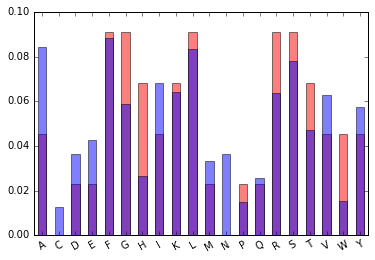

In [182]:
extremely_misclassified_plotting(lr, X_test,y_test, n_std= 3, position = 0 )

(<matplotlib.axes._subplots.AxesSubplot at 0x1354a9e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1354a9e10>)

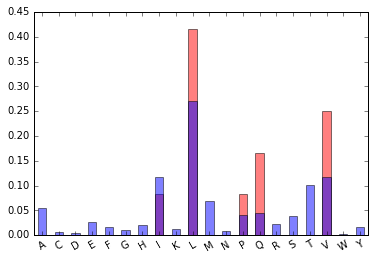

In [184]:
extremely_misclassified_plotting(lr, X_test,y_test, n_std= 4, position = 1 )

(<matplotlib.axes._subplots.AxesSubplot at 0x134236940>,
 <matplotlib.axes._subplots.AxesSubplot at 0x134236940>)

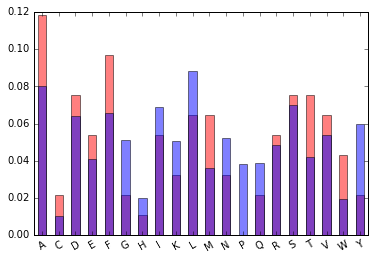

In [172]:
extremely_misclassified_plotting(lr, X_test,y_test, n_std= 2, position = 2 )

(<matplotlib.axes._subplots.AxesSubplot at 0x133cd9e80>,
 <matplotlib.axes._subplots.AxesSubplot at 0x133cd9e80>)

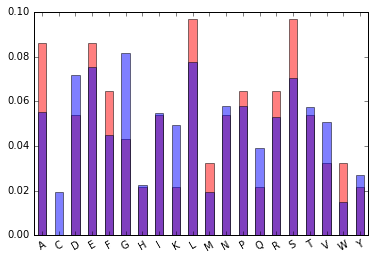

In [173]:
extremely_misclassified_plotting(lr, X_test,y_test, n_std= 2, position = 3 )

(<matplotlib.axes._subplots.AxesSubplot at 0x1345777b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1345777b8>)

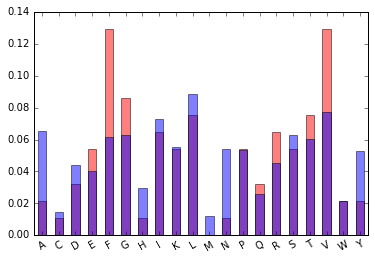

In [174]:
extremely_misclassified_plotting(lr, X_test,y_test, n_std= 2, position = 4 )

(<matplotlib.axes._subplots.AxesSubplot at 0x13483c470>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13483c470>)

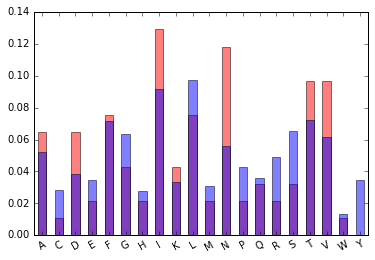

In [175]:
extremely_misclassified_plotting(lr, X_test,y_test, n_std= 2, position = 5 )

(<matplotlib.axes._subplots.AxesSubplot at 0x1349fe320>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1349fe320>)

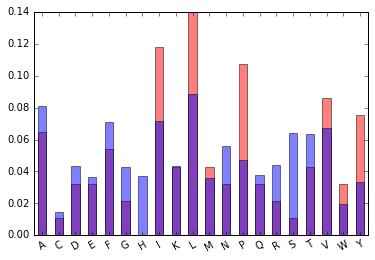

In [176]:
extremely_misclassified_plotting(lr, X_test,y_test, n_std= 2, position = 6 )

(<matplotlib.axes._subplots.AxesSubplot at 0x134d9d470>,
 <matplotlib.axes._subplots.AxesSubplot at 0x134d9d470>)

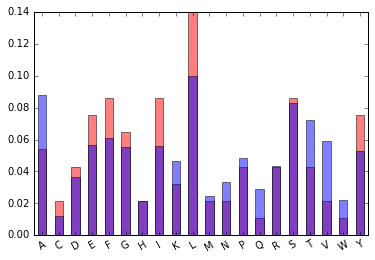

In [177]:
extremely_misclassified_plotting(lr, X_test,y_test, n_std= 2, position = 7 )

(<matplotlib.axes._subplots.AxesSubplot at 0x134eb6390>,
 <matplotlib.axes._subplots.AxesSubplot at 0x134eb6390>)

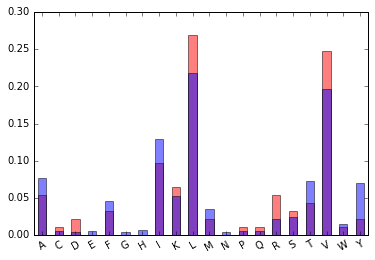

In [178]:
extremely_misclassified_plotting(lr, X_test,y_test, n_std= 2, position = 8 )